<a href="https://colab.research.google.com/github/doublezz10/RW_model_example/blob/main/Rescorla_Wagner_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Reinforcement learning: How to model "gambling" behavior**
Zach Zeisler

Rudebeck Lab - CEYE Day 2020

**Who am I?**

I'm starting the third year of my PhD in the Rudebeck Lab. Right now, my project is focused on optimizing MAPseq (a super cool way to study brain anatomy that I'll talk about this afternoon) for use in non-human primates. I'm broadly interested in the structural basis of cognition, comparative neuroanatomy, and how amygdala and prefrontal cortex are critical for the computations that underlie complex behaviors - like we'll be talking about today!

Here's my [email](mailto:zach.zeisler@icahn.mssm.edu) and my [Twitter](https://twitter.com/zachzeisler1) if you're interested in connecting with me!


![my headshot](https://icahn.mssm.edu/files/fad_img_new/255/0000076810083888249091/0000072500078348997201.jpg)

# Behavioral modelling - rationale

We talked briefly during Pete's lecture about how the amygdala is involved in processing rewards and guiding behavior to maximize them. In this short exercise, we'll explore a task designed to study this kind of decision making behavior, introduce the concept of computational modelling, and build our own simple reinforcement model to closely study some real behavioral data!

First, a brief reminder of what **prediction errors** are:

![prediction errors](https://i.ibb.co/Ypdc97H/predictionerror.png)

The brain is constantly making predictions about the world. Sometimes these predictions are correct, but often times, they aren't (like in the cartoon above). In these cases where the outcome is not what we had expected, we need to update our predictions, so that in future scenarios, we have a better chance of making the correct prediction.

**Prediction error** is the brain's way of calculating how different the real world is from what we expected. But, it is not optimal to totally change our expectations based on only one exposure; rather, it should take multiple times seeing bears behind trees to assume that behind every tree there is a bear. This is where the concept of **learning rate** comes into the equation. One way to think about learning rate is that it is how important each exposure is. Higher learning rate means that it would take fewer instances of seeing bears to assume that all trees have bears behind them. These two factors go into an equation called the Rescorla-Wagner Model to allow us to predict someone's new expectation based on prior experiences. A simplified equation for the model is below:


$New Expectation = Old Expectation + Learning Rate * Prediction Error$

## Task design

We're going to provide you with some data to explore. The data was collected from a task like this. Participants are allowed to choose one of three slot machines; each one has a different chance of giving out a reward (pretend that there are only two outcomes: win or lose). The participants' goal is to learn (by trial-and-error) which choices give them the highest chance of a reward, and gather as many rewards as possible over 300 trials. The best option switches at some point during the experiment (called a reversal), so participants must constantly adapt in order to succeed. We're going to look at data from one participant playing this game, and see what we can discover about learning and decision making.

![task design](https://i.ibb.co/JydtCpN/slots.png)

# Download data, prepare to analyze

This is a Python notebook - there's a lot of code buried under the titles below, but you dont need to worry about that :) 

Below are a couple of cells to get the simulation up and running; simply click the play button (which will appear if you hover over the [   ]'s) to the left of each cell in order to run it. These first couple may take a little while to run as we download and format the data.

In [ ]:
#@title Set up programming environment

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import ipywidgets as widgets       # interactive display
from ipywidgets import interact, interact_manual
%config InlineBackend.figure_format = 'retina'
# plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

# import data

trial_choice_reward = np.genfromtxt("https://raw.githubusercontent.com/doublezz10/RW_model_example/main/trial_choice_reward.csv",delimiter=',')
trial_choice_reward[0,0] = 1

ntrials = 300
noptions = 3

# calculate choice matrix
choice_1 = np.zeros((300,1))
choice_2 = np.zeros((300,1))
choice_3 = np.zeros((300,1))

for i in range(ntrials):

  if trial_choice_reward[i,1] == 1:
    choice_1[i,0]=1
  else: 
    choice_1[i,0]=0

  if trial_choice_reward[i,1] == 2:
    choice_2[i,0]=1
  else:
    choice_2[i,0]=0

  if trial_choice_reward[i,1] == 3:
    choice_3[i,0]=1
  else:
    choice_3[i,0]=0

choices_together = np.hstack((choice_1,choice_2,choice_3))

# calculate choice rates (over 10 trials)
choice_1_rate = np.zeros((300,1))
choice_2_rate = np.zeros((300,1))
choice_3_rate = np.zeros((300,1))

for j in range(ntrials):
  choice_1_rate[j,0] = np.mean(choice_1[j:j+9])
  choice_2_rate[j,0] = np.mean(choice_2[j:j+9])
  choice_3_rate[j,0] = np.mean(choice_3[j:j+9])

In [ ]:
#@title What do the data look like?
#@markdown Run this cell to show the first 5 rows (trials) of the data. The first column is the trial number, the second column is the choice the participant made on that trial, and the third column is whether or not they were rewarded for that choice. This will be the basis for all of our analysis.

print(trial_choice_reward[:5,:])

[[1. 3. 0.]
 [2. 1. 1.]
 [3. 3. 0.]
 [4. 3. 0.]
 [5. 3. 0.]]


# Basic stats - are they helpful?

Here, we'll plot some simple statistics from the data and see what we can learn from them. Press the play button to generate some graphs and think about what they mean.

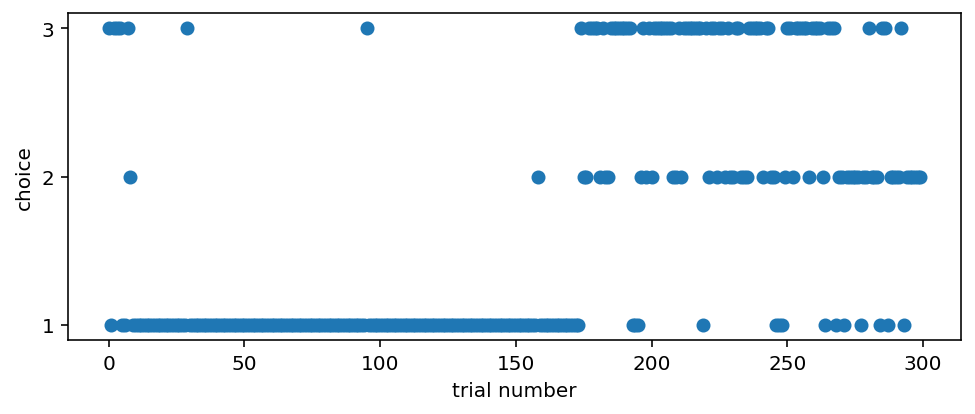

In [ ]:
#@title Choices by trial
#@markdown Can you estimate when the reversal occurred? Around which trial?

plt.figure(figsize=(8,3))
plt.xlabel('trial number')
plt.ylabel('choice')
plt.yticks((1,2,3))
plt.scatter(range(ntrials),trial_choice_reward[:,1]);

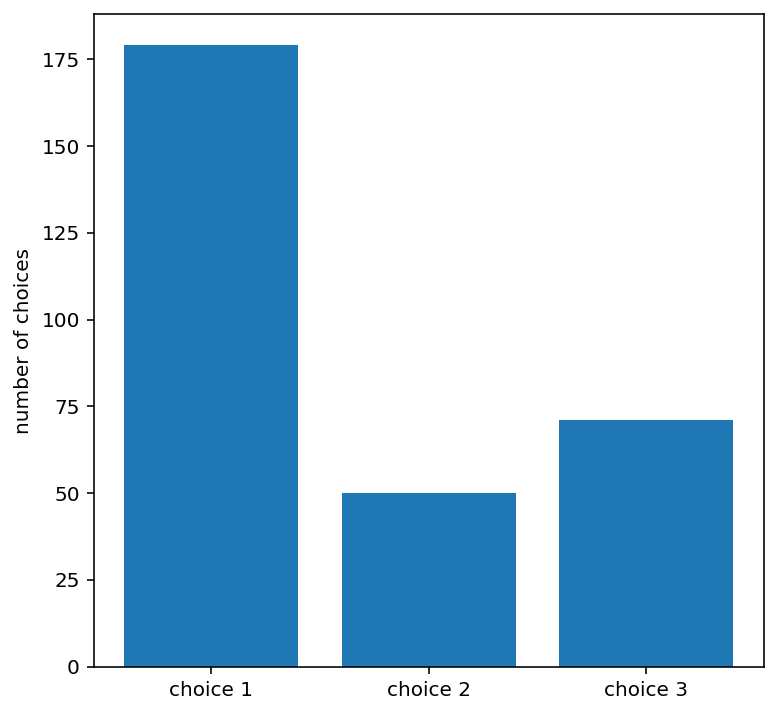

In [ ]:
#@title Choice frequency
#@markdown How many times did the participant make each choice? Does this tell us which choice is best?

plt.figure(figsize=(6,6))
plt.bar([0,1,2],(np.sum(choice_1),np.sum(choice_2),np.sum(choice_3)))
plt.xticks((0,1,2),('choice 1','choice 2','choice 3'))
plt.ylabel('number of choices');


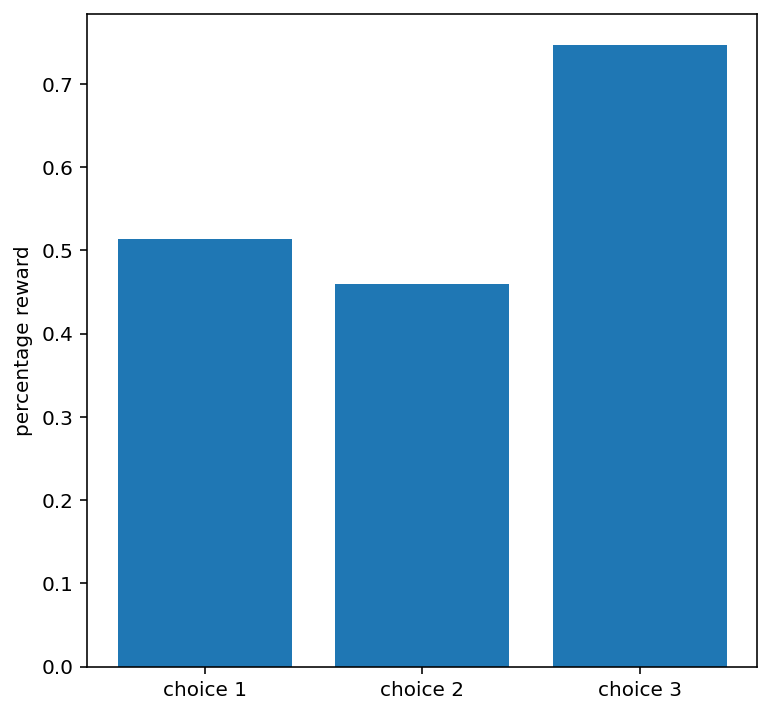

In [ ]:
#@title Reward frequency
#@markdown Which choice led to the most rewards (on average)? Is this helpful to know?

plt.figure(figsize=(6,6))

reward_choice_1 = []
reward_choice_2 = []
reward_choice_3 = []

for i in range(ntrials):
  if trial_choice_reward[i,1] == 1:
    if trial_choice_reward[i,2] == 1:
      reward_choice_1.append(1)
    else:
      reward_choice_1.append(0)
  elif trial_choice_reward[i,1] == 2:
    if trial_choice_reward[i,2] == 1:
      reward_choice_2.append(1)
    else:
      reward_choice_2.append(0)

  elif trial_choice_reward[i,1] == 3:
    if trial_choice_reward[i,2] == 1:
      reward_choice_3.append(1)
    else:
      reward_choice_3.append(0)

plt.bar([0,1,2],[np.mean(reward_choice_1),np.mean(reward_choice_2),np.mean(reward_choice_3)])
plt.xticks((0,1,2),('choice 1','choice 2','choice 3'))
plt.ylabel('percentage reward');

## Pause here for discussion
While these kinds of figures can give us a basic intuition of how the task works, they don't tell us anything about how the participant is learning the task, nor how they are deciding which option to choose. We'll need to do some more complicated analysis to look into these things.

# Let's make a model!
Now, we'll implement a model to see what is happening on a trial-by-trial basis (this model is called a Rescorla-Wagner Model if you're curious to learn more)! This model computes a **prediction error** (how different is the outcome compared to what I was expecting) and multiplies it by a **learning rate** to update an estimation of the true value.

Use this cell below to alter the learing rate. Type any value between 0 and 1, and *remember to run the cell* after changing it.

In [ ]:
learning_rate = 0.1

The participant made the best choice 75.33 % of the time.


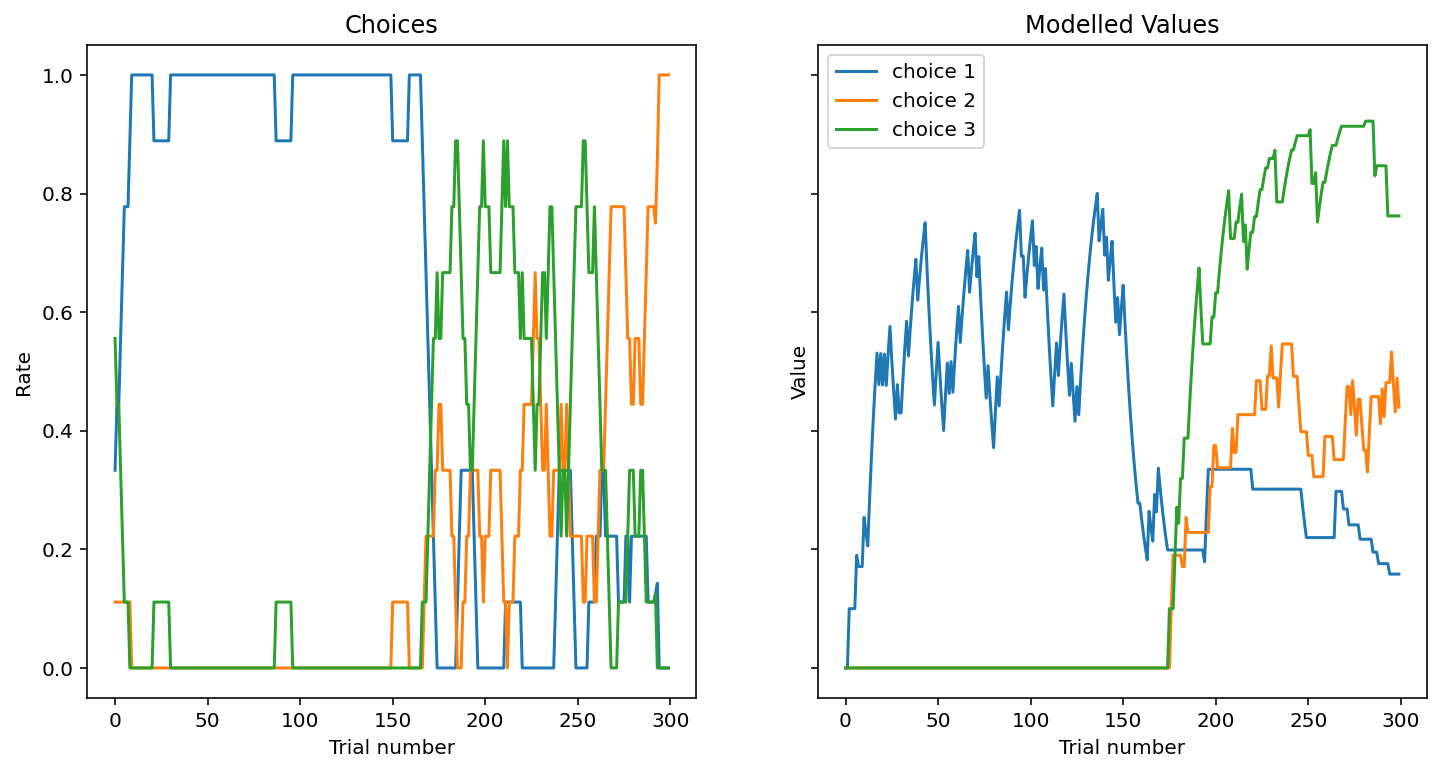

In [ ]:
#@title Initiate the model and plot the data!
#@markdown *Re-run this cell every time you change the learning rate*

#@markdown The plot on the left shows the rate that the participant chooses each option, and the plot on the right shows the predicted value of each choice.

#@markdown Try adjusting the learning rate and seeing how the plots change - can you figure out what the learning rate is doing? What is the best value? Try to maximize the percentage of "correct" choices.

choice_1_value = np.zeros((300,1))
choice_2_value = np.zeros((300,1))
choice_3_value = np.zeros((300,1))
for i in range((ntrials-1)):
  if choice_1[i] == 1:
    new_value = choice_1_value[i] + learning_rate*(trial_choice_reward[i,2]-choice_1_value[i])
  else:
    new_value = choice_1_value[i]
  choice_1_value[i+1] = new_value

  if choice_2[i] == 1:
    new_value = choice_2_value[i] + learning_rate*(trial_choice_reward[i,2]-choice_2_value[i])
  else:
    new_value = choice_2_value[i]
  choice_2_value[i+1] = new_value

  if choice_3[i] == 1:
    new_value = choice_3_value[i] + learning_rate*(trial_choice_reward[i,2]-choice_3_value[i])
  else:
    new_value = choice_3_value[i]
  choice_3_value[i+1] = new_value

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(12,6))
ax1.plot(range(ntrials),choice_1_rate,label='choice 1')
ax1.plot(range(ntrials),choice_2_rate,label='choice 2')
ax1.plot(range(ntrials),choice_3_rate,label='choice 3')
ax1.set_xlabel('Trial number')
ax1.set_ylabel('Rate')
ax1.set_title('Choices')

ax2.plot(range(ntrials), choice_1_value,label='choice 1')
ax2.plot(range(ntrials), choice_2_value,label ='choice 2')
ax2.plot(range(ntrials), choice_3_value,label ='choice 3')
ax2.set_xlabel('Trial number')
ax2.set_ylabel('Value')
ax2.set_title('Modelled Values')
ax2.legend();

value_by_trial = np.zeros((300,3))
max_val_choice = []
for trial in range(ntrials):
  value_by_trial[trial,0] = choice_1_value[trial]
  value_by_trial[trial,1] = choice_2_value[trial]
  value_by_trial[trial,2] = choice_3_value[trial]
  max_val_choice.append(np.argmax(value_by_trial[trial,:]))

best_choice = []
for trial in range(ntrials):
  if choices_together[trial,max_val_choice[trial]] == 1:
    best_choice.append(1)
  else:
    best_choice.append(0)
print('The participant made the best choice', "%.2f" % (np.mean(best_choice)*100),'% of the time.')

## Pause here for discussion

The best learning rate is 0.16
The accuracy of that learning rate is 0.76


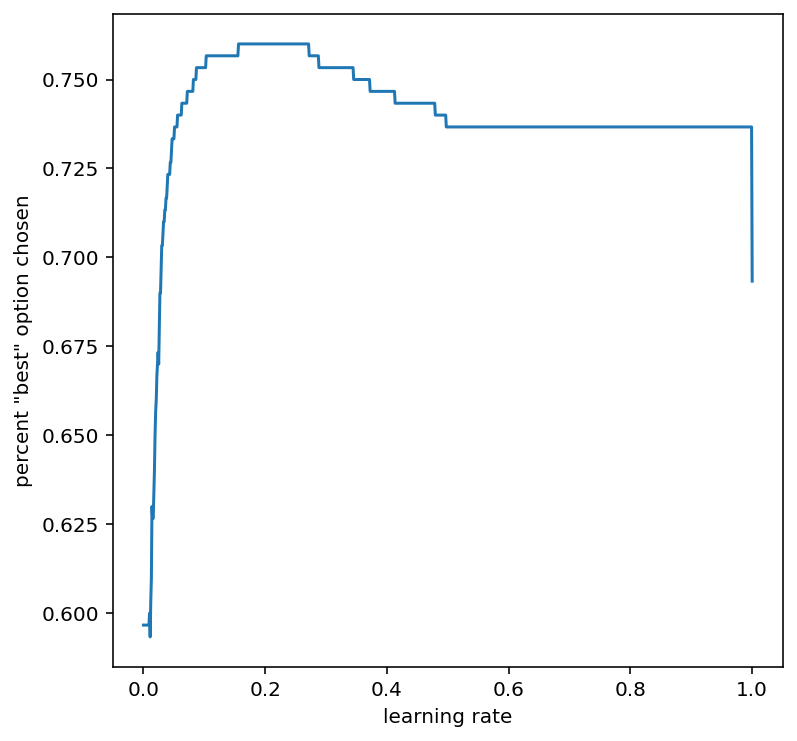

In [ ]:
#@title Let's find the best learning rate
#@markdown Instead of manually trying every single learning rate, we can compute the accuracy for 1000 values between 0 and 1 and see which has the highest accuracy. This is the power of computation (this will take a minute to calculate, don't worry if it seems slow)! This way, we'll have the "true" learning rate that best explains our participant's behavior.

accuracies = []

for rates in np.linspace(0,1,1000):
  choice_1_val = np.zeros((300,1))
  choice_2_val = np.zeros((300,1))
  choice_3_val = np.zeros((300,1))
  for i in range((ntrials-1)):
    if choice_1[i] == 1:
      new_val1 = choice_1_val[i] + rates*(trial_choice_reward[i,2]-choice_1_val[i])
    else:
      new_val1 = choice_1_val[i]
    choice_1_val[i+1] = new_val1

    if choice_2[i] == 1:
      new_va2l = choice_2_val[i] + rates*(trial_choice_reward[i,2]-choice_2_val[i])
    else:
      new_val2 = choice_2_val[i]
    choice_2_val[i+1] = new_val2

    if choice_3[i] == 1:
      new_val3 = choice_3_val[i] + rates*(trial_choice_reward[i,2]-choice_3_val[i])
    else:
      new_val3 = choice_3_val[i]
    choice_3_val[i+1] = new_val3

  val_by_trial = np.zeros((300,3))
  max_val_choices = []
  for trial in range(ntrials):
    val_by_trial[trial,0] = choice_1_val[trial]
    val_by_trial[trial,1] = choice_2_val[trial]
    val_by_trial[trial,2] = choice_3_val[trial]
    max_val_choices.append(np.argmax(val_by_trial[trial,:]))

  best_choices = []
  for trial in range(ntrials):
    if choices_together[trial,max_val_choices[trial]] == 1:
      best_choices.append(1)
    else:
      best_choices.append(0)
  accuracy = np.mean(best_choices)
  accuracies.append(accuracy)

plt.figure(figsize=(6,6))
plt.xlabel('learning rate')
plt.ylabel('percent "best" option chosen')
plt.plot(np.linspace(0,1,1000),accuracies);
print('The best learning rate is', "%.2f" % np.linspace(0,1,1000)[np.argmax(accuracies)])
print('The accuracy of that learning rate is',"%.2f" % np.max(accuracies))

## Discussion questions

How do you think Patient SM would perform on this task? What would her learning rate be (would it be high or low)?

How can you explain the shape of the last graph? (ie why does it go up at first, then go back down)

# What do we do with all of this?

I hope it's clear that using modelling techniques can give us much more insight into behavior and learning than simple analyses. But where do we go from here?

Remember that all of this data and analysis is based on **one** experiment and **one** participant. Imagine if the participant did this same task again: would they be better or worse? Imagine that we compared this participant's performance to other participants' - we could see how different factors affect one's learning rate.

If we were to run this experiment on animals and not humans, we could see how different experimental manipualtions affect their performance. We could also study their neural activity (in a variety of ways), to understand what different parts of the brain are doing during this task.

The possibilities for follow-up studies are nearly endless! This is why computational models (like this simple Rescorla-Wagner example) are so useful. It's also why they're so widely implemented across different fields of neuroscience and computer science. In fact, Amazon and Netflix use models very similar to this one, albeit a bit more complicated, to recommend you products to buy and shows to watch

I hope this was interesting! You can save this exercise to your own Google Drive if you ever want to look back it (go to File/Save a Copy in Drive), and feel free to reach out if you have questions or want to learn more!

![Rudebeck Lab members as babies](https://i.ibb.co/n10rTDm/babies.jpg)